[*********************100%***********************]  1 of 1 completed


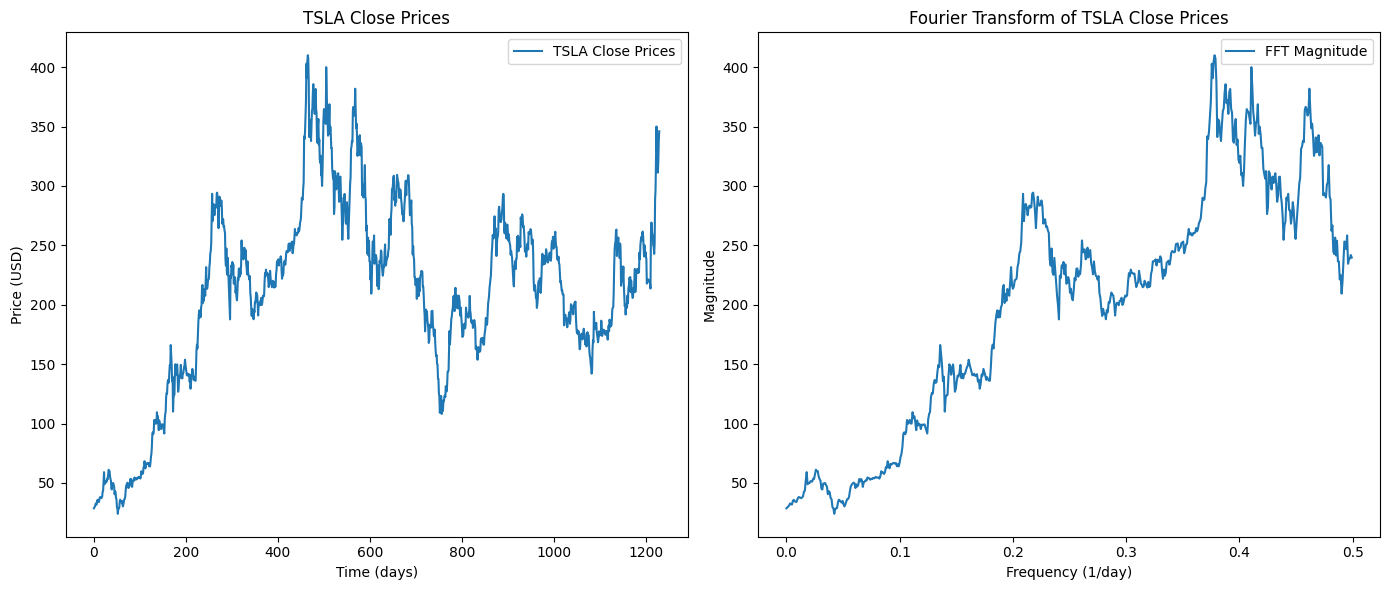

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# TSLA 데이터를 가져오기
tsla_data = yf.download('TSLA', start='2020-01-01', end='2024-11-20')
tsla_close = tsla_data['Close']

# 데이터 준비
close_prices = tsla_close.values
n = len(close_prices)
t = np.linspace(0, n-1, n)  # 시간축 (단순히 인덱스를 시간으로 사용)

# 푸리에 변환 수행
fft_values = fft(close_prices)
frequencies = fftfreq(n, d=1)  # d=1은 단위 시간 간격

# 절대값(크기)만 사용하여 시각화
fft_magnitudes = np.abs(fft_values)

# 결과 시각화
plt.figure(figsize=(14, 6))

# 원본 데이터
plt.subplot(1, 2, 1)
plt.plot(t, close_prices, label='TSLA Close Prices')
plt.title("TSLA Close Prices")
plt.xlabel("Time (days)")
plt.ylabel("Price (USD)")
plt.legend()

# 푸리에 변환 결과
plt.subplot(1, 2, 2)
plt.plot(frequencies[:n//2], fft_magnitudes[:n//2], label='FFT Magnitude')  # 양의 주파수만 표시
plt.title("Fourier Transform of TSLA Close Prices")
plt.xlabel("Frequency (1/day)")
plt.ylabel("Magnitude")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 8.1 MB/s eta 0:00:00


In [ ]:
import backtrader as bt
import yfinance as yf
from datetime import datetime
import numpy as np
import pandas as pd
from itertools import product

# Load the CSV file
file_path = '/content/conditon3.csv'
df_csv = pd.read_csv(file_path)

def find_sell_condition(cci, inc):
  # Iterate through each row in the dataframe
  for index, row in df_csv.iterrows():
      if (row['buy_threshold'] <= cci and cci <= row['sell_threshold'] and row['add_inc_lower'] >= inc and inc >= row['add_inc_upper']):
          return 1  # Stop checking further rows once a match is found
  return 0

class CCIStrategy(bt.Strategy):
    params = (
        ('cci_period', 18),     # CCI의 기본 기간
        ('buy_threshold', 50),  # 매수 임계값
        ('sell_threshold', 70), # 매도 임계값
        ('add_inc_lower', 0.05),
        ('add_inc_upper', 0.05),
        ('add_buy_drop', 0.05), # 추가 매수 조건 (10% 하락)
    )

    def __init__(self):
        self.cci = bt.indicators.CommodityChannelIndex(self.data, period=self.params.cci_period)
        self.last_cci = 0
        self.price_profit = []
        self.trade_dates = []  # 매수/매도 날짜 기록
        # Initialize a flag to track if the condition is met

    def next(self):
        date = self.data.datetime.date(0)  # 현재 데이터의 날짜
        cash = self.broker.get_cash()      # 현재 가용 자금
        price = self.data.close[0]         # 현재 종가
        size = int(cash / price)           # 살 수 있는 최대 주식 수
        #print(f"condition : {self.cci[0]}, {self.cci[0] - self.last_cci}")

        # Buy condition and find_sell_condition(self.cci[0], self.cci[0] - self.last_cci) == 0
        if not self.position and find_sell_condition(self.cci[0], self.cci[0] - self.last_cci) == 0:
            self.buy(size=size)
            #print(f"buy cci : {self.cci[0]}, price : {price}")
            self.trade_dates.append({"action": "buy", "date": date, "price": price})
        # Sell condition
        elif find_sell_condition(self.cci[0], self.cci[0] - self.last_cci) == 1 and self.position:
            profit = price - self.position.price
            self.sell(size=self.position.size)
            self.price_profit.append(profit)
            #print(f"1매수 가격: {self.position.price}, 매도 가격: {price}, 수익: {profit}")
            self.trade_dates.append({"action": "sell", "date": date, "price": price})

        self.last_cci = self.cci[0]

    def stop(self):
        if self.position:
            price = self.data.close[0]
            date = self.data.datetime.date(0)
            profit = price - self.position.price
            self.sell(size=self.position.size)
            self.price_profit.append(profit)
            #print(f"2매수 가격: {self.position.price}, 매도 가격: {price}, 수익: {profit}")
            self.trade_dates.append({"action": "final_sell", "date": date, "price": price})

# Fetch data from Yahoo Finance using yfinance
def fetch_data(symbol, start, end):
    data = yf.download(symbol, start=start, end=end)
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    data.columns = ['open', 'high', 'low', 'close', 'volume']
    return data

# US stock symbols
us_stock_symbols = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NVDA", "ADBE",
    "ORCL", "INTC", "JPM", "BAC", "C", "GS", "MS", "JNJ", "PFE", "UNH", "KO", "DIS",
    "V", "MA", "HD", "WMT", "PG", "XOM", "CVX", "PEP", "NKE", "COST",
    "NFLX", "T", "VZ", "BA", "MRK", "ABBV", "AMGN", "CRM", "QCOM", "IBM", "BITX"
]

us_stock_symbols = [
   "TSLA","NVDA"
]


all_trades = []  # 통합 데이터를 저장할 리스트

for symbol in us_stock_symbols:
    start_date = "2021-01-01"
    end_date = "2024-11-16"
    df = fetch_data(symbol, start=start_date, end=end_date)
    data = bt.feeds.PandasData(dataname=df)

    cerebro = bt.Cerebro()

    # Use a container to hold the strategy instance
    strategy_container = {}

    def strategy_creator(*args, **kwargs):
        strategy_container['instance'] = CCIStrategy(*args, **kwargs)
        return strategy_container['instance']

    cerebro.addstrategy(strategy_creator)
    cerebro.adddata(data)
    cerebro.broker.setcash(100000)
    cerebro.run()

    # Access the strategy instance after running cerebro
    strategy_instance = strategy_container.get('instance')
    if strategy_instance is None:
        continue

    trade_date = strategy_instance.trade_dates

    # Save all trades to a CSV file
    trade_date_df = pd.DataFrame(trade_date)
    output_file = symbol + "_trades.csv"
    trade_date_df.to_csv(output_file, index=False)

    profits = strategy_instance.price_profit
    wins = len([p for p in profits if p > 0])
    losses = len([p for p in profits if p <= 0])
    win_rate = (wins / len(profits) * 100) if profits else 0
    average_profit = sum([p for p in profits if p > 0]) / wins if wins > 0 else 0
    average_loss = sum([p for p in profits if p <= 0]) / losses if losses > 0 else 0
    #print(f"Final Portfolio Value: ${cerebro.broker.getvalue():.2f}")
    all_trades.append({
        "symbol": symbol, "Total Trades": len(profits), "Winning Trades": wins, "Losing Trades": losses,
        "Win Rate": win_rate, "Average Profit": average_profit, "Average Loss": average_loss, "total_money" : cerebro.broker.getvalue()
    })


# Save all trades to a CSV file
all_trades_df = pd.DataFrame(all_trades)
output_file = "all_trades.csv"
all_trades_df.to_csv(output_file, index=False)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
